# Flamingo 2.0

The Flamingo toolbox has been redesigned to improve the workability with varying datasets and to improve the integrity of the data. 

The Flamingo toolbox comprises a workflow that is highly sensitive to the order of operations. For example, if features are extracted from a segmentated image and afterwards the segmentation is recomputed, then also the features extraction needs to be recomputed. If the order of operations is incorrect, results might be incorrect or at least not reproducible.

At the same time, the Flamingo workflow is computationally and storage intensive. Unnecessary repititions of (faulty) operations should be avoided at any time. By adopting an object oriented workflow, order and data integrity can be monitored. In addition, all related data is stored into a single entity that can be written to a single file. Therefore the workability with varying datasets and the portability of datasets improves as well.

This notebook introduces the new Flamingo workflow by example.

## Requirements

In [1]:
# enable logging
import logging
logging.basicConfig(level=logging.WARNING) # set logging level (logging.DEBUG shows it all)
logger = logging.getLogger(__name__)

# enable plotting
import matplotlib.pyplot as plt

# import flamingo workflow
from flamingo import FlamingoBase, \
                     FlamingoImage, \
                     FlamingoDataset, \
                     FlamingoDatasetPartition, \
                     FlamingoModel, \
                     FlamingoIO, \
                     FlamingoHash, \
                     FlamingoBlockchain
                    

/Users/hoonhout/Python/VirtualEnvs/flamingo/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ModuleNotFoundError: No module named 'postprocess'

## The Flamingo object

The Flamingo toolbox distinguishes 4 main classes that are introduced in this notebook:

* ``FlamingoImage``
* ``FlamingoDataset`` 
* ``FlamingoDatasetPartition``
* ``FlamingoModel``

All 4 main classes inherit from the ``FlamingoBase`` class. The ``FlamingoBase`` class cannot be used on its own, but implements functionalities that are shared amongst all Flamingo classes. These shared functionalities are most characteristic for the new Flamingo workflow and are therefore briefly introduced.

### Object configuration

Flamingo classes can all take a JSON configuration file upon initialization (keyword ``config``). The configuration file holds most configuration options, like:

* image crop
* image region of interest (ROI)
* segmentation resolution
* segmentation method
* features
* partitions

A single configuration file can be shared between Flamingo objects. Each object simply reads what it needs and discards the rest. The structure of the configuration file is still under debate.

An example of a current configuration file is:

````
{
    "segmentation": {
        "roi": [
            {
                "filename_pattern": "*.c3.*",
                "roi_file": "roi1.txt"
            },
            {
                "filename_pattern": "*.c4.*",
                "roi_file": "roi2.txt"
            }
        ],
        "extract_contours": true,
        "remove_disjoint": false,
        "method_params": {
            "n_segments": 15000,
            "compactness": 10
        },
        "method": "slic"
    },
    "features": {
        "colorspace": "rgb",
        "blocks": ["pixel", "intensity", "shape"],
        "blocks_params": {"properties_intensity": ["mean_intensity"]}
    },
    "image": {
        "crop": [0, 0, 0, 0]
    },
    "partitions": {
        "test": 0.25,
        "validate": 0.25,
        "train": 0.5,
        "n": 1
    }
}
````

### Object reading/writing

Any Flamingo object can be written to a compressed zip archive using the ``dump`` method. Reading previously written Flamingo object files is done using the ``load`` methode. In the zip archive, each object attribute is represented in a separate file. Python primitives are stored as human-readible JSON. More complex objects are stored as (slower) Pickle files. Some Flamingo objects contain lists of other Flamingo objects. For example, the ``FlamingoDataset`` object contains a list of ``FlamingoImage`` objects. Such collections are stored in the compressed zip archive as a series of uncompressed zip archives.
  
Flamingo objects can also be read/written partially. Specific attributes can be included/excluded from reading/writing to save memory/storage. Note that with partial data some functionalities of a Flamingo object will be disabled. However, data integrity is still preserved with partial data by replacing the excluded attributes by their attribute hash (see next item). 
  
The actual writing and reading of Flamingo objects is implemented in the ``FlamingoIO`` class.

### Object hashes

A hash is a semi-unique string representation of an object. A hash is like the object's fingerprint. A hash is reproducible, i.e. the same object will result in the same hash. But the object cannot be restored from a hash. Hash computation is usually quick, opposed to, for example, zipping. A hash can be used to quickly check if an object has changed, but it cannot be used to see what has changed.
  
Object hashes are used to preserve data integrity and log dependencies. For example, if a ``FlamingoModel`` object is trained using a specific dataset and partition, the dataset and partition hashes are stored in the ``FlamingoModel`` object. Consequently, the resulting model can always be linked to it's training dataset and partition and thus reproduced.
  
An example of an object hash is: ``8a56f75c86875ccce5b4012e61ee166c``.

### Object blockchain and integrity

A blockchain is a series of hashes that are stored at different stages in a workflow. The object hash is stored before and after the object state changes. If data integrity is preserved, i.e. the order of operations is correct, the hash stored at the end of stage #1 equals the hash stored at the start of stage #2. Similarly, the hash stored at the end of stage #2 should equal the hash stored at the start of stage #3, etc. Data integrity is preserved if this series of hashes is complete. This series is referred to as the blockchain.
  
If stage #2 is recomputed, also stage #3 should be recomputed. The blockchain implementation checks before any operation if it can break the blockchain. If so, it will raise an error. The user can disable the error by setting the ``preserve_integrity`` attribute to ``False``. Similarly, the blockchain implementation checks before any operation if the blockchain up to the current workflow stage is intact. If not, it will raise and error and force the user to restore the blockchain. This behavior cannot be disabled.
  
The actual blockchain is implemented in the ``FlamingoBlockchain`` class. The data integrity preservation is implemented in the ``workflow`` decorator. The user can display the blockchain using ``obj._blockchain.print_chainage()``.
  
An example of a blockchain is:

````
Stage      Function             Hashes (before)                  Hashes (after)                  
-------------------------------------------------------------------------------------------------
0          load_config          None                             8a56f75c86875ccce5b4012e61ee166c
           apply_roi            None                             a113c6a0214ac8a53ada7a0bebe207bc
           apply_crop           None                             a113c6a0214ac8a53ada7a0bebe207bc
           imread               None                             a113c6a0214ac8a53ada7a0bebe207bc
2          create_segmentation  a113c6a0214ac8a53ada7a0bebe207bc 6cef867cf5262928edde3e1ecaac5c54
                                8a56f75c86875ccce5b4012e61ee166c                                 
3          extract_features     6cef867cf5262928edde3e1ecaac5c54 cfc2016d32b06135a77c61c7b7fd6e7b

Consistent chainage: True
````

### Object description

Any Flamingo object can hold a simple descriptive text for identification. Set it using the ``set_description`` method. It will display when printing a Flamingo object, along with its hash and timestamp.

## The FlamingoImage class

The ``FlamingoImage`` class contains all functionalities to preprocess an arbitrary image for the use within the Flamingo workflow. The ``FlamingoImage`` class is not aware of any relations between images. The ``FlamingoImage`` class implements:

* Image reading
* Image segmentation
* Feature extraction
* Feature statistics
* Annotation storage

However, ``FlamingoImage`` does not implement normalization of features based on dataset-wide feature statistics as it involves relations between images. Computation of dataset-wide feature statistics is done by the ``FlamingoDataset`` class. Normalization is done by the ``FlamingoModel`` class, just prior to training.

Now, let's create a ``FlamingoImage`` object:

In [2]:
# select JPEG file
jpgfile = '/data/datasets/beachusers/1370957403.Tue.Jun.11_13_30_03.UTC.2013.kijkduin.c3.snap.jpg'

# select configuration file
cfgfile = '/data/datasets/beachusers/flamingo.json'

# create FlamingoImage class
image = FlamingoImage(jpgfile,
                      config=cfgfile,
                      description='My First Flamingo Image Object, Hooray!')

print(image)

Flamingo Image Object:

  My First Flamingo Image Object, Hooray!

  hash : e7a9df083197143d728bcefdfce4cf23
  time : 2017-07-21 13:04:38
  name : 1370957403.Tue.Jun.11_13_30_03.UTC.2013.kijkduin.c3.snap.jpg



Note that if you rerun the cell above, the hash will not change, but the timestamp will. If you change the image or configuration file, also the hash changes as that will change the object state.

Now, let's segmentate the image:

In [3]:
image.create_segmentation()

print(image)

Flamingo Image Object:

  My First Flamingo Image Object, Hooray!

  hash : 68cacbec39f909e461e0a72812654b93
  time : 2017-07-21 13:04:51
  name : 1370957403.Tue.Jun.11_13_30_03.UTC.2013.kijkduin.c3.snap.jpg



/flamingo/virtualenvs/flamingo/local/lib/python2.7/site-packages/skimage/segmentation/slic_superpixels.py:96: UserWarning: Default value of keyword `sigma` changed from ``1`` to ``0``.
  warnings.warn('Default value of keyword `sigma` changed from ``1`` '


Note that now the hash changed as we added a segmentation to the ``FlamingoImage`` object. The blockchain has also been appended in the background as to log the increment in workflow stage.

Now, let's extract some features:

In [4]:
image.extract_features()

print(image)

/flamingo/checkouts/flamingo/flamingo/classification/features/blocks.py:262: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  df.ix[i, 'size'] = np.prod(segments.shape) / feature['area']
/flamingo/checkouts/flamingo/flamingo/classification/features/features.py:47: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  for k, v in features.ix[1].iteritems():


Flamingo Image Object:

  My First Flamingo Image Object, Hooray!

  hash : c8fef81a6f0ba518becba99accf6fba3
  time : 2017-07-21 13:05:39
  name : 1370957403.Tue.Jun.11_13_30_03.UTC.2013.kijkduin.c3.snap.jpg



Again, the hash has changed and the blockchain was appended. We can check if the blockchain works as we should not be allowed to recompute the segmentation anymore as we incremented the workflow stage:

In [5]:
image.create_segmentation()

ValueError: Modification of stage 2 by rerunning "create_segmentation" might break the blockchain and force you to rerun "extract_features". If this is intentional, set object.preserve_integrity=False. Good luck.

See? Data integrity!

Now, let's finalize the ``FlamingoImage`` object by adding some random annotation data:

In [6]:
n = len(np.unique(image.segmentation))

annotation = np.random.randint(0, 10, size=(n,))
image.add_annotation(annotation)
    
print(image)

Flamingo Image Object:

  My First Flamingo Image Object, Hooray!

  hash : 085e3a0967a345a5a863b615df2faed2
  time : 2017-07-21 13:05:56
  name : 1370957403.Tue.Jun.11_13_30_03.UTC.2013.kijkduin.c3.snap.jpg



Note that by adding an annotation, some basic compatibility checks are performed. For example, if the number of annotated segments matches the segmentation. Also note that this annotation is random. Rerunning this cell will therefore change the hash every time.

Now, let's write the finalized ``FlamingoImage`` object to file. By default, the file is created next to the original image, with the same name, but an extension ``.fio``:

In [7]:
image.dump()

We can restore the object from file. If everything went right, the hash should not have changed. Let's check:

In [8]:
import os

fiofile = '%s.fio' % os.path.splitext(jpgfile)[0]

image2 = FlamingoImage()
image2.load(fiofile)

# or at once
image3 = FlamingoImage(fiofile)

print(image)
print(image2)
print(image3)

Flamingo Image Object:

  My First Flamingo Image Object, Hooray!

  hash : 085e3a0967a345a5a863b615df2faed2
  time : 2017-07-21 13:06:01
  name : 1370957403.Tue.Jun.11_13_30_03.UTC.2013.kijkduin.c3.snap.jpg

Flamingo Image Object:

  My First Flamingo Image Object, Hooray!

  hash : 085e3a0967a345a5a863b615df2faed2
  time : 2017-07-21 13:06:31
  name : 1370957403.Tue.Jun.11_13_30_03.UTC.2013.kijkduin.c3.snap.jpg

Flamingo Image Object:

  My First Flamingo Image Object, Hooray!

  hash : 085e3a0967a345a5a863b615df2faed2
  time : 2017-07-21 13:06:33
  name : 1370957403.Tue.Jun.11_13_30_03.UTC.2013.kijkduin.c3.snap.jpg



Three equal hashes, so three equal objects. We can also read partial objects. By reading partial objects, the object state effectively changes and thus the hash potentially changes. This is unwanted behaviour as the data that *is* read did not change, it is just incomplete. The excluded attributes are therefore replaced by representative hashes as to ensure data integrity of the remaining data. Sounds complicated? Let's skip the segmentation data from reading and see:

In [9]:
image4 = FlamingoImage(fiofile, exclude_attributes=['segmentation', 'segmentation_contours'])

print(image4)

print(type(image.segmentation))
print(type(image4.segmentation))

Flamingo Image Object:

  My First Flamingo Image Object, Hooray!

  hash : 085e3a0967a345a5a863b615df2faed2
  time : 2017-07-21 13:06:39
  name : 1370957403.Tue.Jun.11_13_30_03.UTC.2013.kijkduin.c3.snap.jpg

<type 'numpy.ndarray'>
<class 'flamingo.objects.FlamingoHash'>


## The FlamingoDataset class

Training of a classification model is performed on a collection of preprocessed images: a dataset. The ``FlamingoDataset`` class implements the following dataset-wide operations:

* Adding images
* Aggregated feature statistics
* Dataset partitioning
* Convenience methods for model generation and training

Let's create a ``FlamingoDataset`` object with a single image:

In [2]:
# select JPEG file
fiofile = '/data/datasets/beachusers/1370957403.Tue.Jun.11_13_30_03.UTC.2013.kijkduin.c3.snap.fio'

# select configuration file
cfgfile = '/data/datasets/beachusers/flamingo.json'

dataset = FlamingoDataset([fiofile],
                          config=cfgfile,
                          description='My First Flamingo Dataset Object, Hooray!')

print(dataset)

Flamingo Dataset Object:

  My First Flamingo Dataset Object, Hooray!

  hash : 6ed44decbafc8e36d81a710528dde08b
  time : 2017-07-21 13:27:39
  images : 1
  partitions : 0
  models : 0



Note that the ``FlamingoDataset`` object now holds a copy of the previously preprocessed image. If you change the ``.fio`` file, it won't affect this dataset. The image contained in the dataset can be altered, resegmentated, but always independent of the file on disk.

Alternatively we can create a dataset from raw image data. In the background the images are converted to ``FlamingoImage`` objects. So, let's create a bit larger dataset:

In [3]:
jpgfiles = '/data/datasets/beachusers/1375*.jpg'

dataset = FlamingoDataset(jpgfiles,
                          config=cfgfile,
                          description='My First Flamingo Dataset Object, Hooray!')

print(dataset)

Flamingo Dataset Object:

  My First Flamingo Dataset Object, Hooray!

  hash : 1d4aaf3ad3a33df1e437439031e951b5
  time : 2017-07-21 13:28:22
  images : 10
  partitions : 0
  models : 0



The ``FlamingoDataset`` class implements a convenience function to preprocess all ``FlamingoImage`` objects at once. Individual images can still be written to file.

Let's preprocess the images, add random annotations and dump the result to individual ``.fio`` files:

In [12]:
dataset.preprocess()

for img in dataset.images:
    n = len(np.unique(img.segmentation))
    annotation = np.random.randint(0, 10, size=(n,))
    img.add_annotation(annotation)
    img.dump()
    
print(dataset)

/flamingo/checkouts/flamingo/flamingo/classification/features/blocks.py:262: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  df.ix[i, 'size'] = np.prod(segments.shape) / feature['area']
/flamingo/checkouts/flamingo/flamingo/classification/features/features.py:47: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  for k, v in features.ix[1].iteritems():
/flamingo/checkouts/flamingo/flamingo/classification/features/blocks.py:262: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer

Flamingo Dataset Object:

  My First Flamingo Dataset Object, Hooray!

  hash : f066a9182344b5095ff7623b452798e0
  time : 2017-07-21 13:18:13
  images : 10
  partitions : 0
  models : 0



Now all our preprocessed images are saved to disk and collected in a dataset we can start processing the dataset as a while. That means we need to compute dataset-wide feature statistics and partitions. Partitions are created based on the settings in the configuration file. For each partition a ``FlamingoDatasetPartition`` object is created. This object only holds the indices of the images in a given dataset that belong to the train, test or validation partition. The primary reason to store this data in a separate Flamingo object rather than a simple list is that a Flamingo object has a hash that can be used to guarantee data integrity. For this reason, the hash of the dataset and all the images within are also stored in the ``FlamingoDatasetPartition`` object.

Let's create a partition:

In [5]:
dataset.compute_statistics()
dataset.create_partitions()

print(dataset)

Flamingo Dataset Object:

  My First Flamingo Dataset Object, Hooray!

  hash : 0f204874787f7f6d109d6222c1c560a5
  time : 2017-07-21 13:35:35
  images : 10
  partitions : 1
  models : 0



Done! The dataset is now ready to train some models. Note that this dataset is an all encompassing entity of your training and testing data. In due time we will also add models to this dataset to obtain a single entity that encompasses an entire project. It is probably worthwhile to save this dataset to a ``.fdo`` file for future reference. But realize that this dataset file will hold a copy of every ``.fio`` file that has been imported. Such large object will take time to write to disk, while rebuilding the dataset is relatively simple if you keep the ``.fio`` files. It is up to you whether you prefer multiple ``.fio`` files or a single ``.fdo`` file. The former is more modular, the latter has guaranteed data integrity and reproducibility.

An intermediate approach might be to store the dataset files, excluding the images. The images are then replaced by their individual hashesh as to ensure data integrity. In this case data reproducibility is still not guaranteed.

For now, let's save the datatset file as well:

In [6]:
dataset.dump('/data/datasets/beachusers/beachusers.fdo')

print(dataset)

Flamingo Dataset Object:

  My First Flamingo Dataset Object, Hooray!

  hash : 0f204874787f7f6d109d6222c1c560a5
  time : 2017-07-21 13:35:42
  images : 10
  partitions : 1
  models : 0


In [5]:
dataset = FlamingoDataset('/data/datasets/beachusers/beachusers.fdo')

print(dataset)

Flamingo Dataset Object:

  My First Flamingo Dataset Object, Hooray!

  hash : 0f204874787f7f6d109d6222c1c560a5
  time : 2017-07-21 14:09:14
  images : 10
  partitions : 1
  models : 0



## The FlamingoModel class

A model is trained based on a ``FlamingoDataset`` and a ``FlamingoDatasetPartition`` object. The corresponding hashes are stored in the ``FlamingoModel`` class for data integrity. The dataset-wide feature statistics are also copied to the ``FlamingoModel`` object as these are required to normalize an unseen image in te future. Normalization is only performed just prior to training or prediction.

But before training a model, we need to create a ``FlamingoModel`` object. This is simply done by:

In [6]:
# select configuration file
cfgfile = '/data/datasets/beachusers/flamingo.json'

model = FlamingoModel(model_type='LR',
                      config=cfgfile,
                      description='My First Flamingo Model Object, Hooray!',
                      C=1.0) # regularization parameter

print(model)

Flamingo Model Object:

  My First Flamingo Model Object, Hooray!

  hash : e754d41eac3e9104068cfa31229696d2
  time : 2017-07-21 14:09:14



The model is yet untrained. You can train the model using the ``train`` method that takes a ``FlamingoDataset`` and ``FlamingoDatasetPartition`` object as input. Optionally, you can also exclude features or apply a class aggregation to the training using the arguments ``exclude_features`` and ``class_aggregation``.

We won't be training a model here, as it takes time. But uncommenting the following line will do the job:

In [7]:
#model.train(dataset, dataset.partitions[0])

A trained model can be used to predict an unseen image. Again we won't do this here as it will require training an entire model. But uncommenting the following line will do the job:

In [8]:
#model.predict(FlamingoImage(fiofile))

Note that the ``FlamingoModel`` object is so far related to the ``FlamingoDataset`` object by hashes, but not really linked. If we change the dataset, the blockchain implementation will not notice the existance of the trained model. For this, we need to train the model from within the dataset object. We can generate a series of models with several variations (e.g. regularization) from the ``FlamingoDataset`` object using the ``generate_models`` method. The resulting ``FlamingoModel`` objects are stored within the ``FlamingoDataset`` object, guaranteeing data integrity and reproducibility. We can train the models against all partitions in the ``FlamingoDataset`` object with the ``train_models`` method.

The result is an all encompassing entity that contains original images, extracted features, dataset-wide normalization parameters, dataset partitions and trained models. Dumping this object to disk will provide you with a (large) file containing your entire project with guaranteed data integrity and reproducibility. In addition, you can dump individual ``FlamingoModel`` objects for operational use.

This is how it is done:

In [9]:
# generate a series of models
dataset.generate_models([dict(model_type='LR', C=0.01),
                         dict(model_type='LR', C=0.1),
                         dict(model_type='LR', C=1.0),
                         dict(model_type='LR', C=10.0)])

# train all models against all partitions
#dataset.train_models()

# dump dataset to disk
# dataset.dump('/data/datasets/beachusers/beachusers_including_models.fdo')

# dump first model to disk
dataset.models[0].dump('/data/datasets/beachusers/beachusers_model1.fmo')

print(dataset)
print(dataset.models)

Flamingo Dataset Object:

  My First Flamingo Dataset Object, Hooray!

  hash : 494c68e9e512634d19d8d083902fdca3
  time : 2017-07-21 14:09:14
  images : 10
  partitions : 1
  models : 4

[Flamingo Model Object:
  hash : 6de7400f0a4a10049b3f4b6c974124cd
  time : 2017-07-21 14:09:14
, Flamingo Model Object:
  hash : 219ed2c8e4b5aa6e9dcd5186fbc540ea
  time : 2017-07-21 14:09:14
, Flamingo Model Object:
  hash : e754d41eac3e9104068cfa31229696d2
  time : 2017-07-21 14:09:14
, Flamingo Model Object:
  hash : f055faf7119423fce9785c5062d490d0
  time : 2017-07-21 14:09:14
]


That's it.

Enjoy your Flamingo dataset. Want to see it? You can extract it from your dataset:

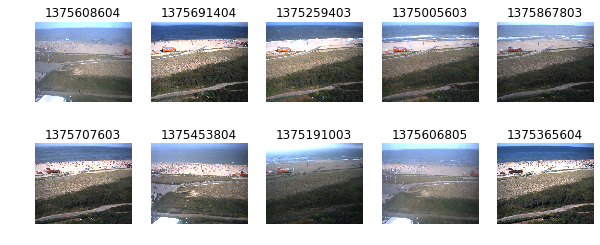

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs.flatten()):
    img = dataset.images[i]
    ax.imshow(img.image)
    ax.set_title(img._name[:10])
    ax.set_axis_off()

Do you want to see all features in the dataset? Here they are:

In [16]:
import pandas as pd

pd.concat([img.features for img in dataset.images])

feature,area,bbox.0,bbox.1,bbox.2,bbox.3,centroid.0,centroid.1,convex_area,eccentricity,equivalent_diameter,...,moments_normalized.7,moments_normalized.8,moments_normalized.9,orientation,perimeter,position.m,position.n,shape,size,solidity
0,0.002008,0.003906,0.000000,0.104492,0.118056,0.058870,0.032369,0.002905,0.711352,0.050559,...,0.006650,0.094586,0.015143,-0.925852,0.782756,0.032369,0.058870,0.003277,166.032057,0.691174
1,0.001909,0.000000,0.003268,0.097168,0.186683,0.049822,0.090412,0.004022,0.829913,0.049306,...,0.012997,0.126172,0.012290,-0.702413,1.290097,0.090412,0.049822,0.001147,174.577060,0.474740
2,0.002081,0.000000,0.022876,0.092773,0.253268,0.046697,0.152518,0.004392,0.828807,0.051472,...,0.011134,0.141789,-0.001533,-0.566533,1.298667,0.152518,0.046697,0.001234,160.191200,0.473831
3,0.001871,0.000000,0.140523,0.088867,0.319853,0.046821,0.220796,0.003551,0.841092,0.048802,...,0.011225,0.135661,0.013475,-0.623075,1.116059,0.220796,0.046821,0.001502,178.200896,0.526775
4,0.001894,0.000000,0.225490,0.084473,0.322304,0.036486,0.282352,0.002325,0.560052,0.049104,...,0.001743,0.098023,-0.005976,-0.366878,0.583736,0.282352,0.036486,0.005558,176.017414,0.814475
5,0.001875,0.000000,0.302288,0.085938,0.410131,0.045121,0.350621,0.002346,0.281418,0.048860,...,0.000227,0.084701,0.007421,-1.331710,0.301926,0.350621,0.045121,0.020568,177.777526,0.799190
6,0.001812,0.000000,0.374592,0.083008,0.453023,0.039387,0.416526,0.001933,0.473867,0.048036,...,0.001893,0.082866,-0.002437,-0.835349,0.236964,0.416526,0.039387,0.032274,183.934549,0.937537
7,0.001798,0.000000,0.448529,0.082031,0.516748,0.040077,0.482879,0.001829,0.207334,0.047847,...,-0.000112,0.081265,-0.000705,1.449631,0.184300,0.482879,0.040077,0.052937,185.383227,0.982846
8,0.001786,0.000000,0.512663,0.081055,0.585376,0.039907,0.549393,0.001900,0.259520,0.047691,...,-0.000473,0.082652,-0.000120,0.947495,0.203231,0.549393,0.039907,0.043249,186.604533,0.940293
9,0.001823,0.000000,0.580065,0.081055,0.653595,0.040083,0.616678,0.001924,0.250340,0.048180,...,-0.000403,0.084338,0.000179,0.647490,0.246088,0.616678,0.040083,0.030105,182.834470,0.947479


# Appendices

## Convert old-style Flamingo files to new-style Flamingo files

In [ ]:
class FlamingoImageConverter:
    '''Class to convert from old-style Flamingo files to new-style Flamingo files'''
    
    
    def __init__(self, imgfile, config):
        
        self.imgfile = imgfile
        self.config = config
        
        self.load_image()
        self.load_segmentation()
        self.load_features()
        self.load_annotation()
        self.load_prediction()
        
        self._obj.update_hash()
        self.mimic_blockchain()
        
        
    def write(self):
        self._obj.dump()
        
        
    def load_image(self):
        if os.path.exists(self.imgfile):
            self._obj = FlamingoImageObject(self.imgfile, config=self.config)
            self._obj._name = self._obj._name.replace('cropped_', '')
        else:
            raise IOError('File not found: %s' % self.imgfile)
            
            
    def load_segmentation(self):
        self._obj.segmentation = self.load_exportfile('segments')
        self._obj.segmentation_contours = self.load_exportfile('contours')
        
                
    def load_features(self):
        features = []
        pklfiles = self.image2export('features.linear.*')
        for pklfile in glob.glob(pklfiles):
            with open(pklfile, 'r') as fp:
                features.append(pickle.load(fp))
        self._obj.features = pd.concat(features, axis=1)
        
        meta = self.load_exportfile('meta')
        if type(meta) is dict and 'stats' in meta.keys():
            self._obj.features_statistics = meta['stats']


    def load_annotation(self):
        try:
            self._obj.add_annotation(self.load_exportfile('classes'))
        except ValueError:
            logger.warn('Cannot read annotation data for: %s' % self.imgfile)
        
        
    def load_prediction(self):
        self._obj.prediction = self.load_exportfile('predict')

        
    def load_exportfile(self, suffix):
        pklfile = self.image2export(suffix)
        if os.path.exists(pklfile):
            with open(pklfile, 'rb') as fp:
                return pickle.load(fp)
        return []

            
    def mimic_blockchain(self):
        hash0 = self._obj._hash
        self._obj._blockchain.append(0, 'load_config', (set([hash0]), hash0, time.time()))
        self._obj._blockchain.append(0, 'apply_roi', (set([hash0]), hash0, time.time()))
        self._obj._blockchain.append(0, 'apply_crop', (set([hash0]), hash0, time.time()))
        self._obj._blockchain.append(0, 'imread', (set([hash0]), hash0, time.time()))
        self._obj._blockchain.append(2, 'create_segmentation', (set([hash0]), hash0, time.time()))
        self._obj._blockchain.append(3, 'extract_features', (set([hash0]), hash0, time.time()))

        
    def image2export(self, suffix):
        fdir, fname = os.path.split(self.imgfile)
        fname, fext = os.path.splitext(fname)
        fname = fname.replace('cropped_', '')
        return os.path.join(fdir, '%s.%s.pkl' % (fname, suffix))
        
    
# convert existsing data
for imgfile in glob.glob('/data/datasets/beachusers/*.jpg'):
    converter = FlamingoImageConverter(imgfile, config='/data/datasets/beachusers/flamingo.json')
    if os.path.exists(converter.image2export('classes')):
        print(imgfile)
        converter.write()

## Create configuration file

In [5]:
import json

config = dict(
    image = dict(
        crop = [0, 0, 0, 0],
    ),
    segmentation = dict(
        method = 'slic',
        method_params = dict(
            n_segments = 200,
            compactness = 10,
        ),
        remove_disjoint = False,
        extract_contours = True,
        roi = [
            dict(
                 vertices = [[ 636,  408],
                             [1399,  380],
                             [2447,  370],
                             [2447,  633],
                             [1909,  661],
                             [1489,  689],
                             [1108,  762],
                             [ 692,  765],
                             [ 400,  786],
                             [ 175,  796],
                             [   0,  814],
                             [   0,  720],
                             [   0,  557],
                             [   0,  425]],
                 filename_pattern = '*.c3.*'
            ),
            dict(
                 vertices = [[   0,  436],
                             [ 390,  432],
                             [ 803,  425],
                             [1538,  425],
                             [2447,  457],
                             [2447,  873],
                             [2030,  852],
                             [1566,  828],
                             [ 980,  810],
                             [ 640,  803],
                             [ 331,  779],
                             [ 210,  803],
                             [  95,  848],
                             [   0,  852],
                             [   0,  696],
                             [   0,  578],
                             [   0,  488]],
                 filename_pattern = '*.c4.*'
            ),
        ],
    ),
    features = dict(
        colorspace = 'rgb',
        blocks = ['pixel', 'intensity', 'shape'],
        blocks_params = dict(
            properties_intensity = ['mean_intensity'],
        ),
    ),
    partitions = dict(
        n = 3,
        train = 0.75,
        test = 0.25,
        validate = 0.,
    ),
)

for i, roi in enumerate(config['segmentation']['roi']):
    np.savetxt('/data/datasets/beachusers/roi%d.txt' % (i+1), roi['vertices'])
    del config['segmentation']['roi'][i]['vertices']
    config['segmentation']['roi'][i]['roi_file'] = ('roi%d.txt' % (i+1))


with open('/data/datasets/beachusers/flamingo.json', 'w') as fp:
    json.dump(config, fp, indent=4)

## Leasons learned

* JPEG is not lossless, therefore the cropped images of the old-style Flamingo datasets are not simply the cropped matrices of the original images, but a recompressed lossy version of these matrices. The new-stye Flamingo datasets are lossless and therefore not the same.
* Hashing through pickle is slow.
* Class attributes are different from instance attributes and not stored.
* UUID column in statistics dataframe is an object and not canonical, therefore it needs to be skipped for hashing.

## Todo

* Check if image already exists in dataset
* Recreate blockchain in converter
* Implement CLI